<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/NER/bilstm_ner_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* http://kaggle.com/shashaalam/ner-using-lstm-with-keras

Data Source:

* https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus


In [1]:
!pip install -U -q seqeval

     |████████████████████████████████| 51kB 2.7MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, accuracy_score, classification_report

In [3]:
seed = 2021
max_len = 250
batch_size = 128
epochs = 100
earlystopping_patience = 10

In [4]:
# Get the raw dataset

!curl -s -LO https://github.com/MahmooudTaha/NLP-2019/raw/master/ner_dataset.csv.zip
!unzip -o ner_dataset.csv.zip
!rm -f ner_dataset.csv.zip

df = pd.read_csv("ner_dataset.csv", encoding="Windows-1252").fillna(method='ffill')
df.head()

Archive:  ner_dataset.csv.zip
  inflating: ner_dataset.csv         


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [5]:

class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w,p,t) for w, p, t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist())]
        
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]


getter = SentenceGetter(df)
sentences = getter.sentences

words = list(set(df["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(df["Tag"].values))
num_tags = len(tags)

word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i,t, in enumerate(tags)}

# print("word2idx: {}".format(word2idx))
print("tag2idx: {}".format(tag2idx))

tag2idx: {'B-org': 0, 'I-geo': 1, 'B-geo': 2, 'B-gpe': 3, 'I-eve': 4, 'I-nat': 5, 'I-per': 6, 'I-tim': 7, 'I-gpe': 8, 'B-tim': 9, 'B-nat': 10, 'I-org': 11, 'B-art': 12, 'B-eve': 13, 'B-per': 14, 'O': 15, 'I-art': 16}


In [6]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences = y, padding="post", value= tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [7]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  loss = history_dict["loss"]
  val_loss = history_dict["val_loss"]

  epochs = range(1, len(acc) + 1)

  # Use plot styling from seaborn.
  sns.set(style="darkgrid")
  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12, 6)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 250)          8794750   
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 200)          280800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 64)           59648     
_________________________________________________________________
time_distributed (TimeDistri (None, 250, 17)           1105      
Total params: 9,136,303
Trainable params: 9,136,303
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
240/240 [==============================] - 115s 335ms/step - loss: 0.3694 - accuracy: 0.9616 - val_loss: 

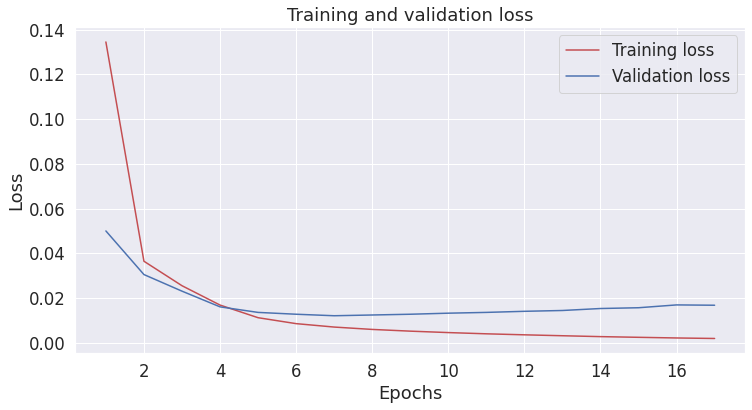

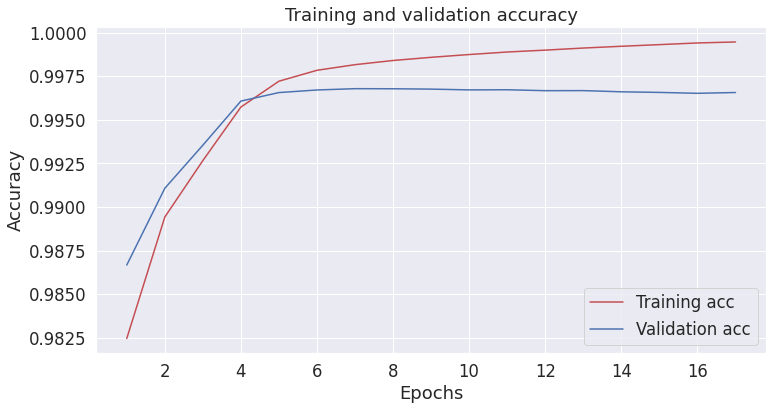

In [8]:
# Create and train model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

input = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input)
# model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True))(model)
model = Bidirectional(LSTM(units=32, return_sequences=True))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input, out)
model.summary()

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(x=X_train,
                    y=np.array(y_train),
                    validation_split=0.2,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[earlystop_callback])

plot_perf(history)

# loss, acc = model.evaluate(x=X_test, y=np.array(y_test), verbose=1)


In [9]:

y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)

y_true_l = []
y_pred_l =[]
for s_y_true, s_y_pred in zip(y_true, y_pred):
  collect_s_y_true = []
  collect_s_y_pred = []
  for w_y_true, w_y_pred in zip(s_y_true, s_y_pred):
    collect_s_y_true.append(tags[w_y_true])
    collect_s_y_pred.append(tags[w_y_pred])
  y_true_l.append(collect_s_y_true)
  y_pred_l.append(collect_s_y_pred)

report = classification_report(y_true=y_true_l, y_pred=y_pred_l, digits=2)
print(report)
print("Testing Accuracy: {}".format(accuracy_score(y_true=y_true_l, y_pred=y_pred_l)))
print("Testing F1-Score: {}".format(f1_score(y_true=y_true_l, y_pred=y_pred_l)))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        83
         eve       0.00      0.00      0.00        70
         geo       0.83      0.85      0.84      7548
         gpe       0.94      0.93      0.94      3222
         nat       0.00      0.00      0.00        35
         org       0.63      0.65      0.64      4071
         per       0.70      0.68      0.69      3401
         tim       0.80      0.83      0.81      4069

   micro avg       0.79      0.79      0.79     22499
   macro avg       0.49      0.49      0.49     22499
weighted avg       0.78      0.79      0.78     22499

Testing Accuracy: 0.9967748123436196
Testing F1-Score: 0.7864839046497678
